In [1]:
!pip install -q tflite-model-maker

In [2]:
import os
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')

import matplotlib.pyplot as plt
import tflite_model_maker
from glob import glob
from PIL import Image, ImageOps

2021-11-03 21:22:16.282316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-03 21:22:16.282347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def thumbnail(image=None, desired_size=None):
    """Resizes original image as close as possible to desired size.
    Preserves aspect ratio of original image.
    Does not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image for AI model detection.
    desired_size : (width, height)
        Size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting for the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    w, h = desired_size
    try:
        # convert from numpy to native Python int type
        # that PIL expects
        if isinstance(w, np.generic):
            w = w.item()
            w = int(w)
            h = h.item()
            h = int(h)
        thumb.thumbnail((w, h))
    except Exception as e:
        msg = (f"Exception in "
                f"PIL.image.thumbnail(desired_size={desired_size}):"
                f"type(width)={type(w)}, type(height)={type(h)}"
                f"\n{e}"
                )
        
        raise RuntimeError(msg)
    
    return thumb


def resize(image=None, desired_size=None):
    """Pad original image to exact size expected by input tensor.
    Preserve aspect ratio to avoid confusing the AI model with
    unnatural distortions. Pad the resulting image
    with solid black color pixels to fill the desired size.
    Do not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image sized to fit an input tensor but without padding.
        Its possible that one size fits one tensor dimension exactly
        but the other size is smaller than
        the input tensor other dimension.
    desired_size : (width, height)
        Exact size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting exactly the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    delta_w = desired_size[0] - thumb.size[0]
    delta_h = desired_size[1] - thumb.size[1]
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(thumb, padding)
    
    assert new_im.size == desired_size
    return new_im

In [4]:
interpreter = tf.lite.Interpreter(model_path="ai_models/tflite-model-maker-falldetect-model-best.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
width, height = 224, 224
input_shape

array([  1, 224, 224,   3], dtype=int32)

In [5]:
def prediction(path_image):

    template_image_src = Image.open(path_image)    
        
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
    img = resize(image=_thumbnail, desired_size=(width, height))
    
    img = np.expand_dims(img,0)
    
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred = "fall" if np.argmax(output_data[0])==0 else "no-fall"
    
    return pred

# Prediction on Single Image

In [6]:
path_image = "Images/fall_img_8.png"
pred = prediction(path_image)
pred

'fall'

# Prediction on Multiple Image

In [7]:
def pred_for_dir(image_list):
    
    image_list = os.listdir('Images/')
        
    frame_to_display = len(image_list) 
    columns = 6
    rows = (frame_to_display // columns) + 1
    
    fig = plt.figure(figsize=(20, 28))

    plt_cnt = 1

    for i in image_list:

        image = Image.open('Images/'+i)
        pred = prediction('Images/'+i)
                
        fig.add_subplot(rows, columns, plt_cnt)
        plt.axis("off")
        
        plt_title = pred

        plt.title(plt_title)        
        plt.imshow(image)

        plt_cnt += 1

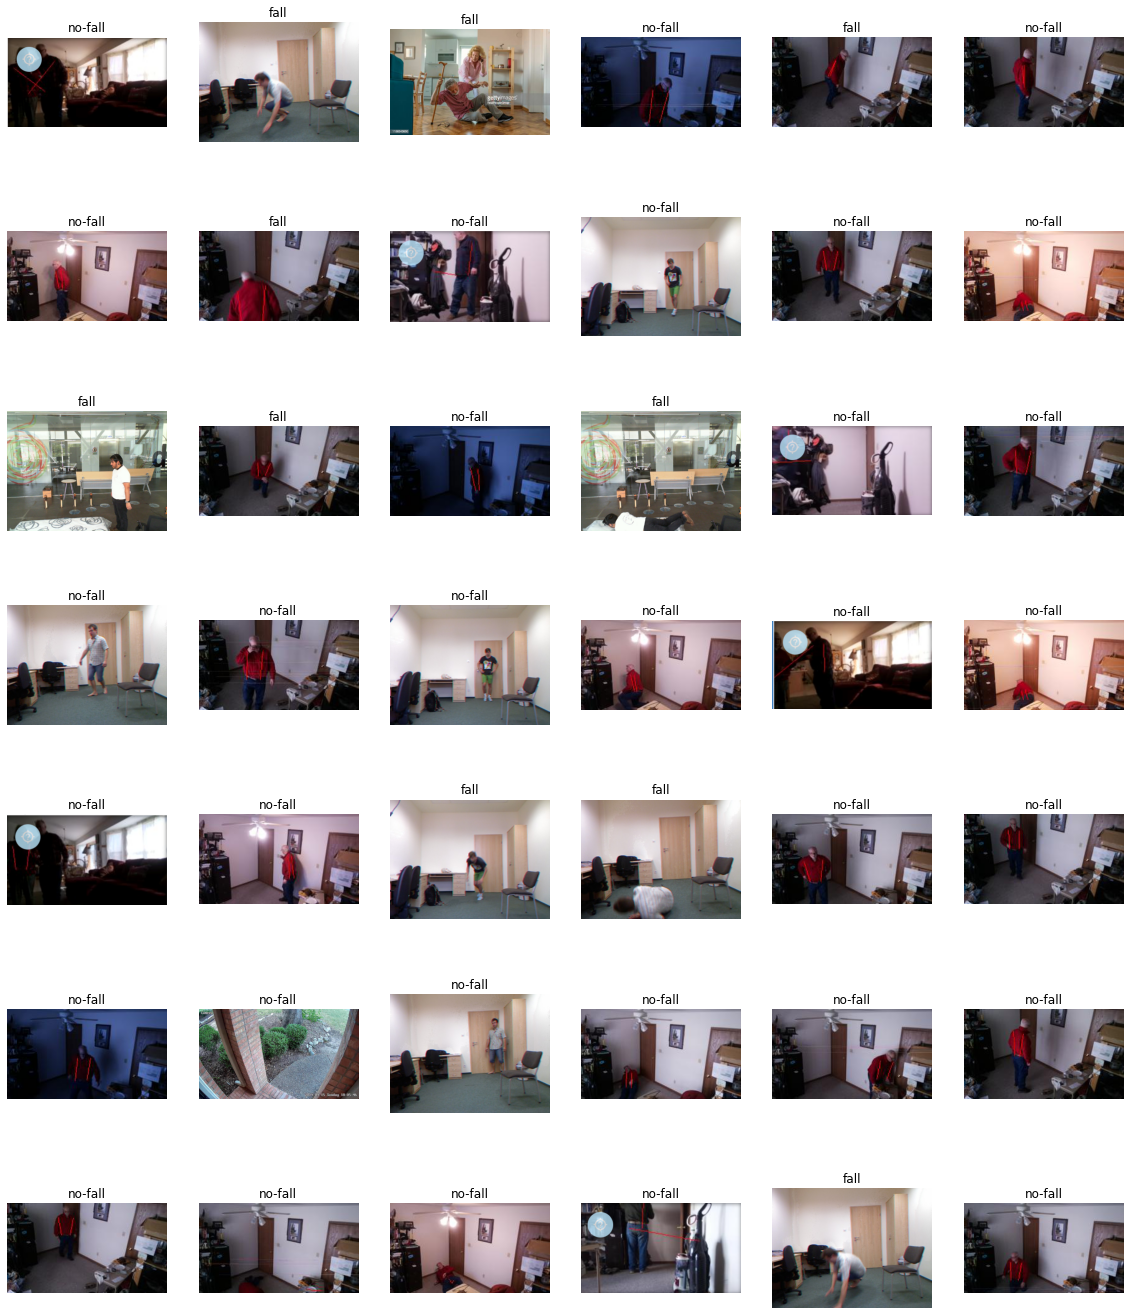

In [8]:
pred_for_dir('Images/')

# Prediction using URL

In [9]:
import requests
from io import BytesIO

Enter URL->https://previews.123rf.com/images/ljupco/ljupco2010/ljupco201000052/156473069-mature-man-sitting-in-an-armchair-and-reading-a-newspaper-in-a-living-room-at-home.jpg


'no-fall'

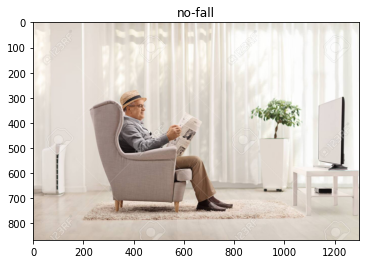

In [10]:
def predict_from_url(url):

    response = requests.get(url)
    template_image_src = Image.open(BytesIO(response.content))
    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
    img = resize(image=_thumbnail, desired_size=(width, height))
    img = np.expand_dims(img,0)
    
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred = "fall" if np.argmax(output_data[0])==0 else "no-fall"
    plt.title(pred)
    plt.imshow(template_image_src)
    
    return pred

predict_from_url(input('Enter URL->'))

In [ ]:
# sample fall images

# https://www.verywellhealth.com/thmb/S5_3kxnfNnzraYArYYSfeLOA9Ws=/1777x1333/smart/filters:no_upscale()/GettyImages-1016885118-5c074c6946e0fb0001d37d79.jpg
# https://i.pinimg.com/originals/af/15/0d/af150de073839d91c26d91fe015c039b.jpg
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRvkYg_rLNNgrhcsNENb8dF0HZZP72-NsvnAA&usqp=CAU
# https://image.shutterstock.com/image-photo/elder-woman-lying-on-floor-260nw-786236107.jpg
# https://i.pinimg.com/474x/f2/14/be/f214bec1273997e4873e7a29053ad30d--elderly-care-safety-tips.jpg
# https://image.shutterstock.com/image-photo/elderly-woman-falling-down-home-260nw-1542815507.jpg
# https://image.shutterstock.com/image-photo/asian-senior-man-falling-down-260nw-1736873057.jpg


# sample non-fall images

# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRVSW_-L0x7w1p4ho82ClVB6t-wd3hu0rbSGw&usqp=CAU
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPxPHJPYa4qC-C1q8ZiVbrN-lP60muQOQV0w&usqp=CAU
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKHmd6AXI-dsPyMVGC0x_9vktzNykdtgDj0g&usqp=CAU
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSXczMrp_LOv12u_RW-Y7GBHZWwtcnwXax8qw&usqp=CAU
# https://thumbor.forbes.com/thumbor/fit-in/900x510/https://www.forbes.com/health/wp-content/uploads/2021/04/medical_alerts_medicare-getty_creative.jpg
# https://bestlifeonline.com/wp-content/uploads/sites/3/2018/06/stressed-out-older-man.jpg